# # Set 3 — Q6
**Task:** The image contains **small, non-overlapping blobs**. Segment the blobs using **thresholding**.


In [1]:
# %%
# --- Imports & Config ---
import cv2
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# === User: set your image path here ===
# If you don't have one, the notebook generates a synthetic blobs image.
img_path = "../image.jpg"   # <-- change this

out_dir = Path("./outputs_q6")
out_dir.mkdir(parents=True, exist_ok=True)

def imshow(ax, img, title="", cmap=None):
    ax.imshow(img if cmap is None else img, cmap=cmap)
    ax.set_title(title); ax.axis("off")

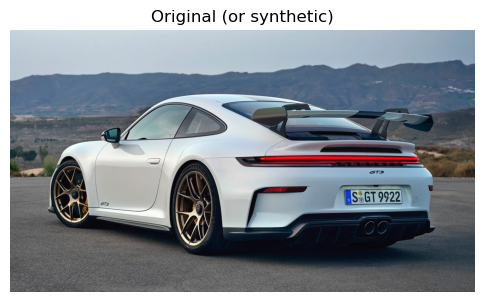

In [2]:
# %%
# --- Load / create image ---
img_bgr = cv2.imread(img_path, cv2.IMREAD_COLOR)
if img_bgr is None:
    # Synthetic non-overlapping blobs (white on black)
    h, w = 400, 600
    synth = np.zeros((h, w), dtype=np.uint8)
    rng = np.random.default_rng(42)
    centers = rng.integers(low=[60,60], high=[w-60, h-60], size=(25,2))
    radii = rng.integers(8, 18, size=centers.shape[0])
    for (cx, cy), r in zip(centers, radii):
        cv2.circle(synth, (int(cx), int(cy)), int(r), 255, -1)
    img_rgb = cv2.cvtColor(synth, cv2.COLOR_GRAY2RGB)
    gray = synth
else:
    img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1,1, figsize=(6,5))
imshow(ax, img_rgb, "Original (or synthetic)")
plt.show()

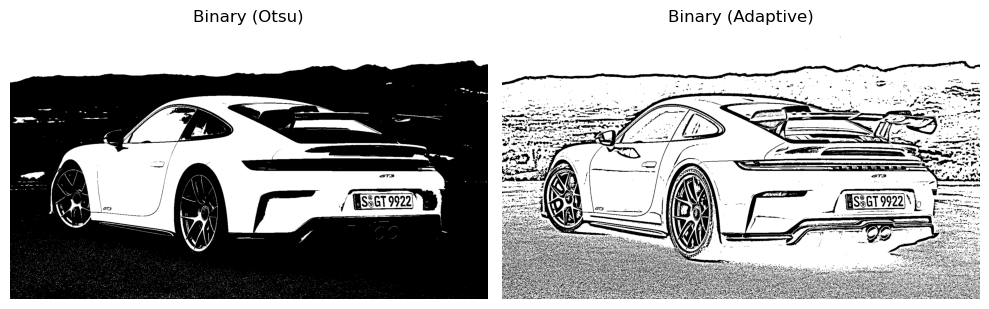

True

In [3]:
# %%
# --- Thresholding ---
# Global Otsu
_, binary_otsu = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)

# Optional: adaptive threshold (useful for uneven illumination)
binary_adapt = cv2.adaptiveThreshold(
    gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 35, 5
)

fig, axs = plt.subplots(1,2, figsize=(10,4))
imshow(axs[0], binary_otsu, "Binary (Otsu)", cmap="gray")
imshow(axs[1], binary_adapt, "Binary (Adaptive)", cmap="gray")
plt.tight_layout(); plt.show()

cv2.imwrite(str(out_dir / "q6_binary_otsu.png"), binary_otsu)
cv2.imwrite(str(out_dir / "q6_binary_adaptive.png"), binary_adapt)

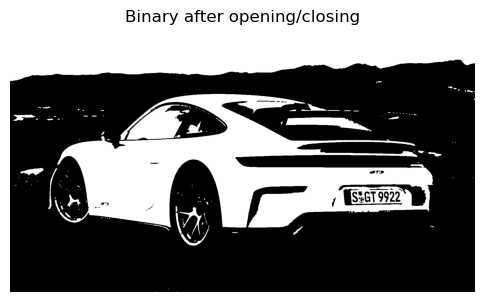

True

In [4]:
# %%
# --- Morphological cleanup ---
kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
binary = cv2.morphologyEx(binary_otsu, cv2.MORPH_OPEN, kernel, iterations=1)
binary = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel, iterations=1)

plt.figure(figsize=(6,5))
plt.imshow(binary, cmap="gray")
plt.title("Binary after opening/closing")
plt.axis("off"); plt.show()

cv2.imwrite(str(out_dir / "q6_binary_clean.png"), binary)

Blob count: 164
Areas (first 10): [275738     59     20     83     47     30     24    117      5     10]
Centroids (first 10): [[ 832.30310295   77.97346394]
 [1417.91525424  197.94915254]
 [1406.7         200.3       ]
 [1689.61445783  219.10843373]
 [1706.87234043  223.85106383]
 [1721.56666667  229.5       ]
 [1746.58333333  233.33333333]
 [1763.72649573  233.95726496]
 [1693.          233.        ]
 [1782.2         235.5       ]]


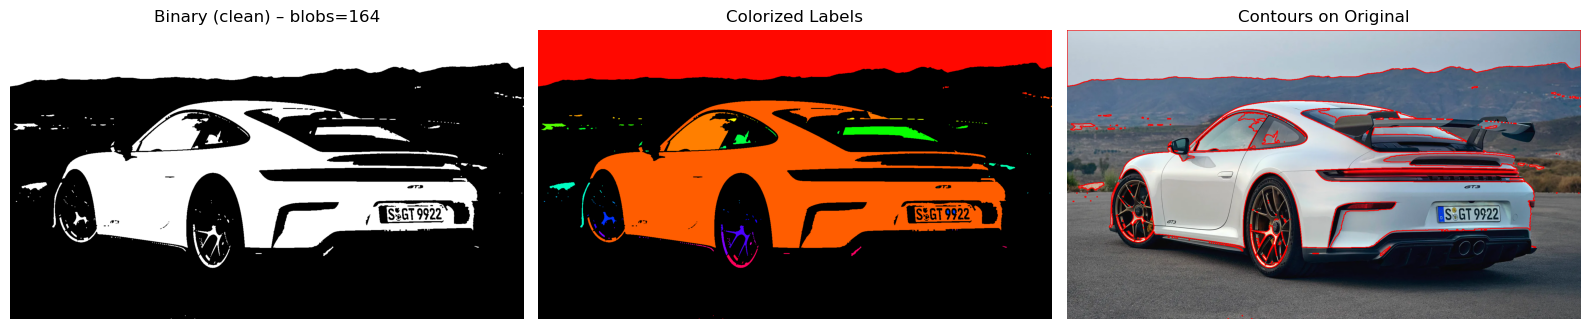

True

In [5]:
# %%
# --- Connected components (labeling) ---
# background=0, foreground blobs=1..N
num_labels, labels, stats, centroids = cv2.connectedComponentsWithStats(binary, connectivity=8)

# Colorize labels
label_hues = (labels.astype(np.float32) / max(1, num_labels)) * 179  # HSV hue
blank_ch = 255 * np.ones_like(labels, dtype=np.uint8)
hsv = np.dstack([label_hues.astype(np.uint8), blank_ch, (labels>0).astype(np.uint8)*255])
label_color = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)

# Overlay contours on original for clarity
contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
overlay = img_rgb.copy()
cv2.drawContours(overlay, contours, -1, (255, 0, 0), 2)

# Count only foreground blobs (exclude label 0)
blob_count = num_labels - 1
areas = stats[1:, cv2.CC_STAT_AREA]
centers = centroids[1:]

print(f"Blob count: {blob_count}")
print(f"Areas (first 10): {areas[:10]}")
print(f"Centroids (first 10): {centers[:10]}")

# Visualize
fig, axs = plt.subplots(1,3, figsize=(16,5))
imshow(axs[0], binary, f"Binary (clean) – blobs={blob_count}", cmap="gray")
imshow(axs[1], label_color, "Colorized Labels")
imshow(axs[2], overlay, "Contours on Original")
plt.tight_layout(); plt.show()

# Save
cv2.imwrite(str(out_dir / "q6_labels_color.png"), cv2.cvtColor(label_color, cv2.COLOR_RGB2BGR))
cv2.imwrite(str(out_dir / "q6_contours_overlay.png"), cv2.cvtColor(overlay, cv2.COLOR_RGB2BGR))